<a href="https://www.kaggle.com/code/dsptlp/faceemotion-fer-2013?scriptVersionId=163435240" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Face Emotion Detection
- Framework - PyTorch
- Base: Resnet50
- Automatic Mixed Precision
- GPU: 1

# Dataset
- FER - 2013
- 36k examples of 48x48 grey scale images of faces, 140MB
- Emotions: happy, sad, fearful, angry, neutral, surprised and disgusted


In [1]:
# Import Packages
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import itertools
from torch.utils.data.sampler import SubsetRandomSampler
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision
import torch.distributed as dist
from torch.cuda.amp import autocast, GradScaler
import torch
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models
from torch import optim
from torch.autograd import Variable
import timm
from timm.scheduler.step_lr import StepLRScheduler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score

# EDA

In [2]:
TRAINDIR="/kaggle/input/fer2013/train"
VALDIR="/kaggle/input/fer2013/test"
IMAGES = 20

classes_train = os.listdir(TRAINDIR)
classes_valid = os.listdir(VALDIR)

print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')

Train Classes - ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']
Validation Classes - ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']


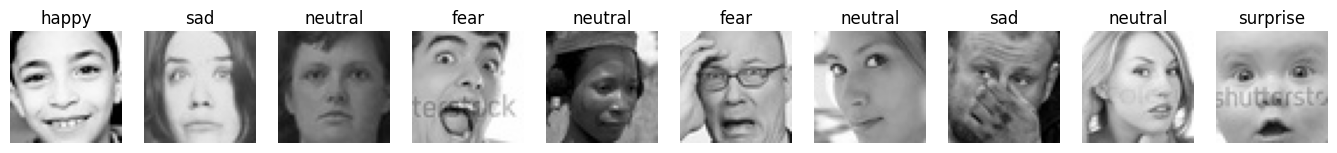

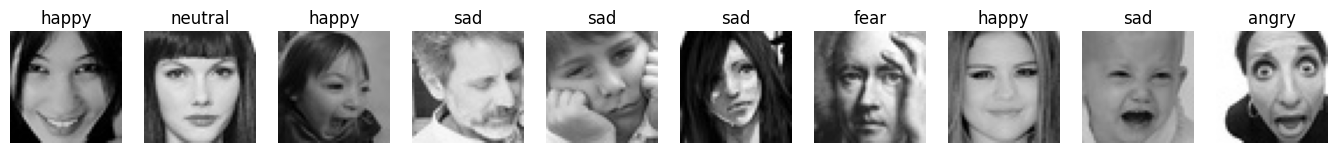

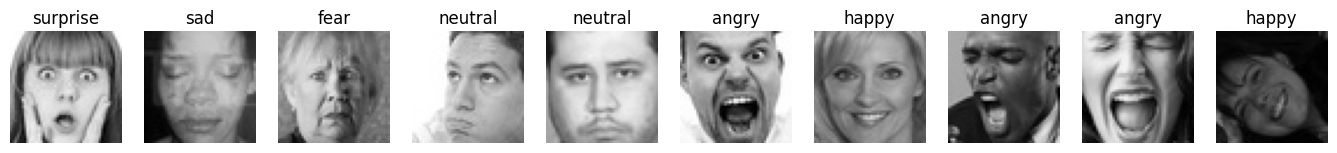

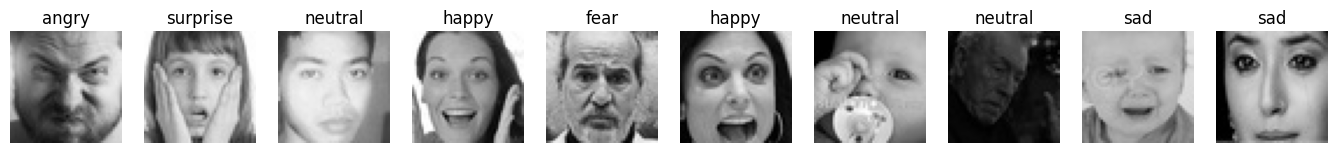

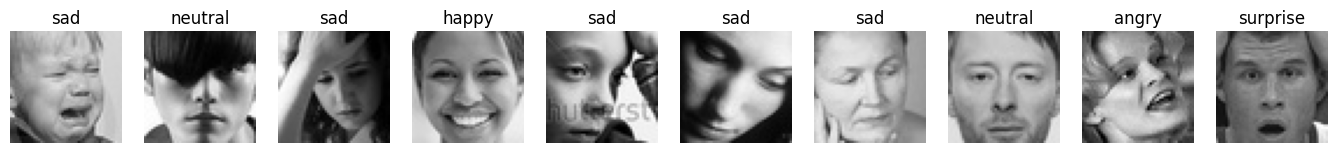

In [3]:
data_dir = TRAINDIR

test_transforms = transforms.Compose([transforms.ToTensor(),])

def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    images, labels = next(iter(loader))  # Get the first batch of data   
    return images, labels, classes

to_pil = transforms.ToPILImage()

counter = 0
while counter < 5:    
    images, labels, classes = get_random_images(10)
    
    fig=plt.figure(figsize=(17,17))
    for ii in range(len(images)):
        image = to_pil(images[ii])
        sub = fig.add_subplot(1, len(images), ii+1)
        res = int(labels[ii])
        sub.set_title(classes[res] )
        plt.axis('off')
        plt.imshow(image)
    
    plt.show()
    counter = counter + 1

# MODEL TRAIN

In [4]:
GPU=0
SEED=1
ARCH = 'resnet50'
EPOCHS = 500
START_EPOCH = 0
LR = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 0.5
PRINT_FREQ = 10
TRAIN_BATCH= 6000
imagesize = 244
VAL_BATCH=TRAIN_BATCH
WORKERS=2
use_autocast = True
LR_EPOCH_DROP = 50

random.seed(SEED)
torch.manual_seed(SEED)
cudnn.deterministic = False
cudnn.benchmark = True

In [5]:
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top5],
        prefix="Epoch: [{}]".format(epoch))

    # Grad Scaler
    scaler = GradScaler()
    # switch to train mode
    model.train()

    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        if GPU is not None:
            images = images.cuda(GPU, non_blocking=True)
        if torch.cuda.is_available():
            target = target.cuda(GPU, non_blocking=True)

        # compute output
        with autocast():
          output = model(images)
          loss = criterion(output, target)

        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))
        
        # use the scaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINT_FREQ == 0:
            progress.display(i)

In [6]:
def validate(val_loader, model, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top5],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            if GPU is not None:
                images = images.cuda(GPU, non_blocking=True)
            if torch.cuda.is_available():
                target = target.cuda(GPU, non_blocking=True)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top5.update(acc5[0], images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % PRINT_FREQ == 0:
                progress.display(i)
        
        print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'.format(top1=top1, top5=top5))

    return top1.avg

In [7]:
def save_checkpoint(state, is_best, filename_in):
    if is_best:
        torch.save(state, 'model_best.pth.tar')

In [8]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

In [9]:
class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [10]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = LR * (0.1 ** (epoch // LR_EPOCH_DROP))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [11]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [12]:
transform_train = transforms.Compose([
    transforms.RandomAffine(degrees=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(0, 5)),    
    transforms.RandomInvert(),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(
    TRAINDIR, transform=transform_train)

transform_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

val_dataset = datasets.ImageFolder(
    VALDIR, transform=transform_val)

train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=TRAIN_BATCH, shuffle=True,
        num_workers=WORKERS, pin_memory=True, sampler=None)

val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=VAL_BATCH, shuffle=True,
        num_workers=WORKERS, pin_memory=True, sampler=None) 

In [13]:
NUM_CLASSES = 7

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

model = timm.create_model(ARCH, pretrained = True, num_classes=NUM_CLASSES)
model = model.to(device)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Scheduler and Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = timm.scheduler.StepLRScheduler(optimizer, decay_t = LR_EPOCH_DROP, decay_rate=WEIGHT_DECAY)

n_steps = len(train_loader.dataset)

In [14]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [15]:
%%time
best_acc1 = 0
best_epoch = 0
lrls = []
for epoch in range(START_EPOCH, EPOCHS):
    #adjust_learning_rate(optimizer, epoch)

    # train for one epoch
    train(train_loader, model, criterion, optimizer, epoch)

    # evaluate on validation set
    acc1 = validate(val_loader, model, criterion)

    # remember best acc@1 and save checkpoint
    is_best = acc1 > best_acc1
    best_acc1 = max(acc1, best_acc1)

    PATH = "M1_" +str(epoch) + "_acc1_" +str(acc1) + "_" + ARCH + ".tar" 
    save_checkpoint({
        'epoch': epoch + 1,
        'arch': ARCH,
        'state_dict': model.state_dict(),
        'best_acc1': best_acc1,
        'optimizer' : optimizer.state_dict(),
    }, is_best,PATH)
    
    scheduler.step(epoch + 1)
    lr_rate =  get_lr(optimizer)
    lrls.append(lr_rate)          
    print('lr: ' + str(lr_rate))

Epoch: [0][0/5]	Time 113.633 (113.633)	Data 31.657 (31.657)	Loss 1.9512e+00 (1.9512e+00)	Acc@1  14.57 ( 14.57)	Acc@5  71.73 ( 71.73)
Test: [0/2]	Time 38.890 (38.890)	Loss 2.0415e+00 (2.0415e+00)	Acc@1  17.00 ( 17.00)	Acc@5  86.93 ( 86.93)
 * Acc@1 17.122 Acc@5 87.016
lr: 0.01
Epoch: [1][0/5]	Time 11.242 (11.242)	Data  9.422 ( 9.422)	Loss 1.6175e+00 (1.6175e+00)	Acc@1  37.10 ( 37.10)	Acc@5  92.95 ( 92.95)
Test: [0/2]	Time  7.324 ( 7.324)	Loss 2.1006e+00 (2.1006e+00)	Acc@1  15.42 ( 15.42)	Acc@5  76.10 ( 76.10)
 * Acc@1 15.102 Acc@5 76.052
lr: 0.01
Epoch: [2][0/5]	Time 11.718 (11.718)	Data  9.923 ( 9.923)	Loss 1.3794e+00 (1.3794e+00)	Acc@1  46.85 ( 46.85)	Acc@5  95.80 ( 95.80)
Test: [0/2]	Time  7.522 ( 7.522)	Loss 2.1944e+00 (2.1944e+00)	Acc@1  22.32 ( 22.32)	Acc@5  74.05 ( 74.05)
 * Acc@1 22.416 Acc@5 74.283
lr: 0.01
Epoch: [3][0/5]	Time 11.123 (11.123)	Data  9.332 ( 9.332)	Loss 1.2327e+00 (1.2327e+00)	Acc@1  52.62 ( 52.62)	Acc@5  97.00 ( 97.00)
Test: [0/2]	Time  7.890 ( 7.890)	Loss 2.00

Text(0, 0.5, 'LR (log scale)')

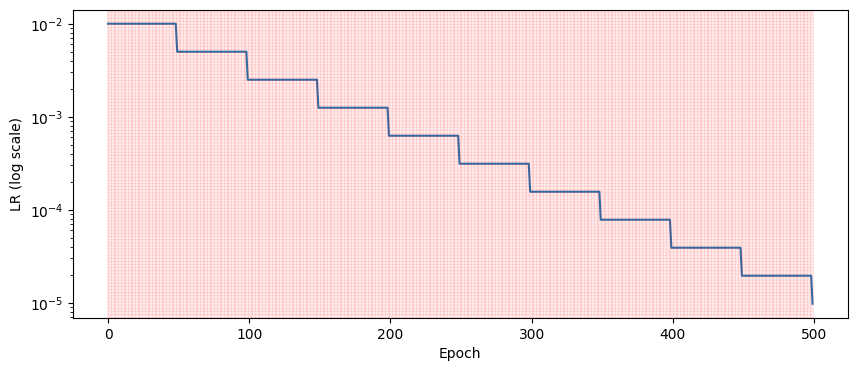

In [16]:
# Plot
ax = pd.Series(lrls).plot(logy=True, figsize = (10, 4))
for i in range(0,EPOCHS,1): 
    ax.axvline(i, linewidth=0.2, color='r', linestyle='--')
ax.set_xlabel("Epoch")
ax.set_ylabel("LR (log scale)")

# RESULTS

In [17]:
def predict_image(image):
    
    model.eval()
    with torch.no_grad():
    
        image_tensor = transform_val(image).float()
        image_tensor = image_tensor.unsqueeze_(0)
        input = Variable(image_tensor)
        input = input.to(device)
        output = model(input)
        index = output.data.cpu().numpy().argmax()
       
    return index

In [18]:
def get_random_images(num):
    data = datasets.ImageFolder(VALDIR, transform=transform_val)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    images, labels = next(iter(loader))  # Get the first batch of data   
    return images, labels, classes

<Figure size 1500x1500 with 0 Axes>

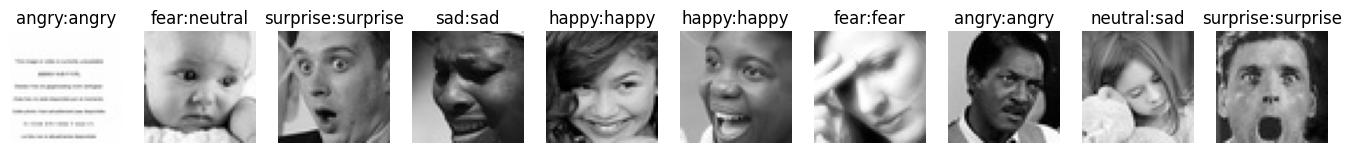

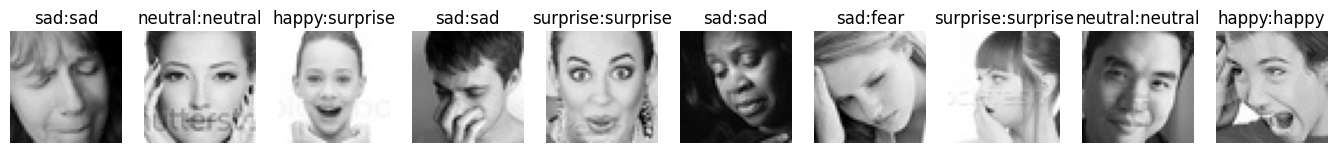

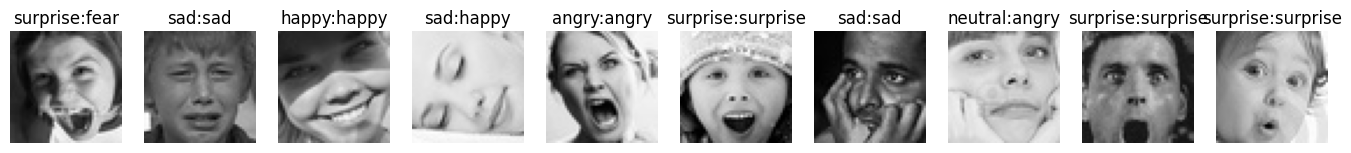

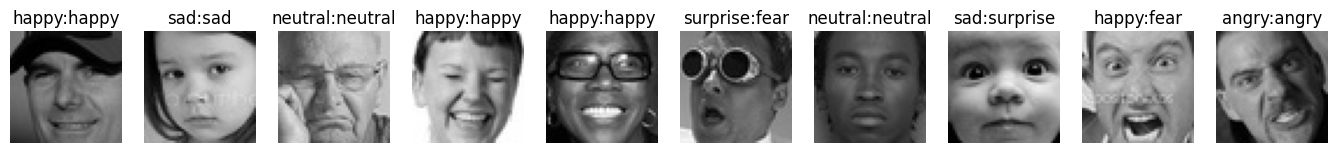

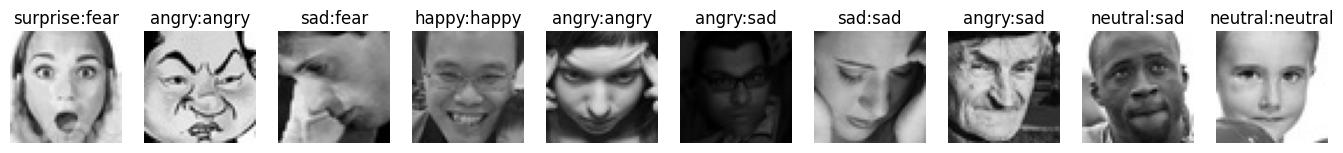

In [19]:
to_pil = transforms.ToPILImage()
images, labels, classes = get_random_images(15)
fig=plt.figure(figsize=(15,15))

counter = 0
while counter < 5:
    to_pil = transforms.ToPILImage()
    images, labels, classes = get_random_images(10)
    fig=plt.figure(figsize=(17,17))
    for ii in range(len(images)):
        image = to_pil(images[ii])
        index = predict_image(image)
        sub = fig.add_subplot(1, len(images), ii+1)
        res = int(labels[ii])
        label_class = int(labels[ii])
        sub.set_title(str(classes[index]) + ":" + classes[label_class])
        plt.axis('off')
        plt.imshow(image)
    plt.show()
    counter = counter + 1

## Confusion Matrix

In [20]:
actual = []
predicted = []

to_pil = transforms.ToPILImage()
images, labels, classes = get_random_images(3000)
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    res = int(labels[ii])
    label_class = int(labels[ii])
    actual.append(classes[label_class])
    predicted.append(str(classes[index]))

In [21]:
cnf_matrix = confusion_matrix(actual, predicted)

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig = plt.figure(figsize=(4, 4),frameon =False, dpi=200)  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[228   4  43  13  48  54  11]
 [  9  24   3   1   2   4   1]
 [ 55   1 204  15  54  81  34]
 [ 17   0  11 632  37  15   9]
 [ 31   1  29  43 313  77   6]
 [ 63   0  47  31  77 302  10]
 [  9   0  22  16  16   6 291]]


<Figure size 640x480 with 0 Axes>

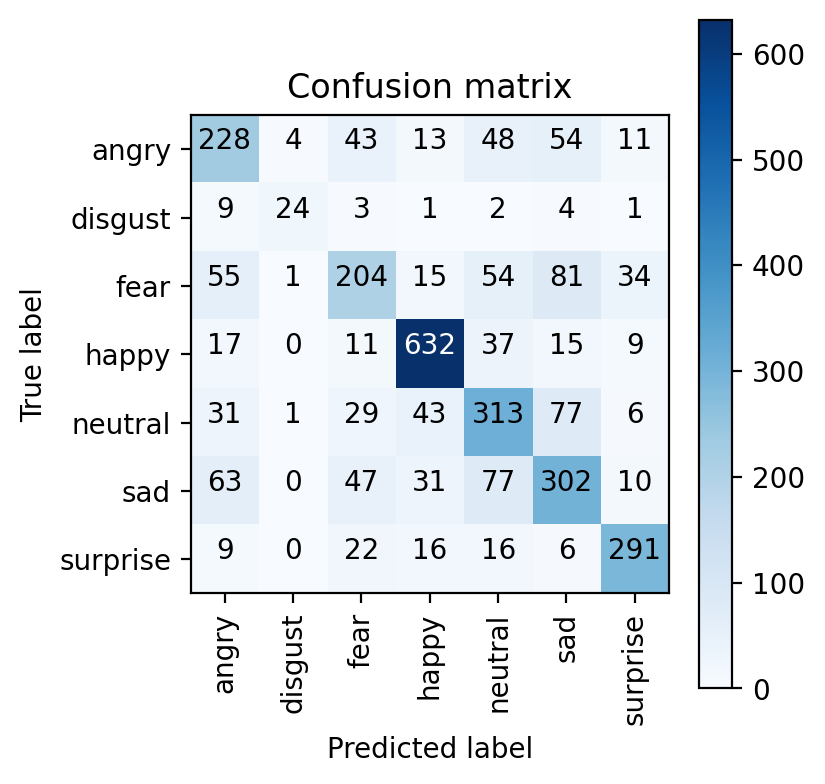

Normalized confusion matrix
[[0.56857855 0.00997506 0.10723192 0.03241895 0.11970075 0.13466334
  0.02743142]
 [0.20454545 0.54545455 0.06818182 0.02272727 0.04545455 0.09090909
  0.02272727]
 [0.12387387 0.00225225 0.45945946 0.03378378 0.12162162 0.18243243
  0.07657658]
 [0.02357836 0.         0.01525659 0.87656033 0.05131761 0.02080444
  0.01248266]
 [0.062      0.002      0.058      0.086      0.626      0.154
  0.012     ]
 [0.11886792 0.         0.08867925 0.05849057 0.14528302 0.56981132
  0.01886792]
 [0.025      0.         0.06111111 0.04444444 0.04444444 0.01666667
  0.80833333]]


<Figure size 640x480 with 0 Axes>

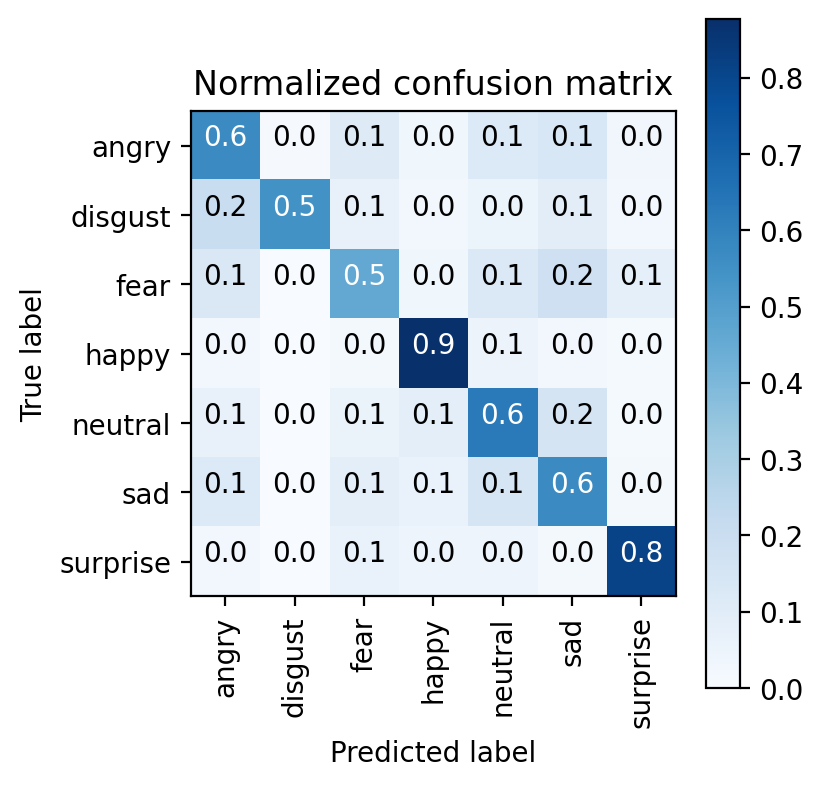

              precision    recall  f1-score   support

       angry       0.55      0.57      0.56       401
     disgust       0.80      0.55      0.65        44
        fear       0.57      0.46      0.51       444
       happy       0.84      0.88      0.86       721
     neutral       0.57      0.63      0.60       500
         sad       0.56      0.57      0.57       530
    surprise       0.80      0.81      0.81       360

    accuracy                           0.66      3000
   macro avg       0.67      0.64      0.65      3000
weighted avg       0.66      0.66      0.66      3000

0.6646666666666666


In [23]:
# Plot non-normalized confusion matrix
plt.figure()
class_names = classes
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix')
plt.show()

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')
plt.show()

print(classification_report(actual, predicted, target_names=class_names))
print(accuracy_score(actual, predicted))